In [97]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


In [98]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)



h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [99]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Cal dates   : 2005-07-01 00:00:00 --- 2006-12-01 00:00:00  (n=18)
Test dates  : 2007-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=18)


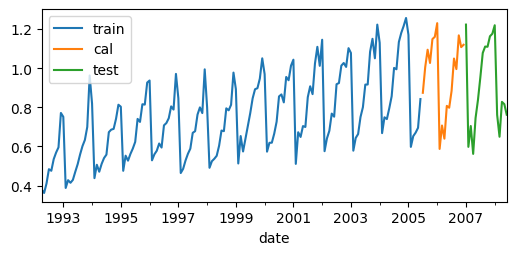

In [100]:
# ==============================================================================
steps = 18
data_train = data[:-steps]
data_train, data_cal = data_train[0:-steps], data_train[-steps:]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)

print(
    f"Cal dates   : {data_cal.index.min()} --- "
    f"{data_cal.index.max()}  (n={len(data_cal)})"
)

print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')

ax.legend();

In [101]:
data_test['y'].name

'y'

In [102]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

# we use 80% of the data for training and 20% for calibrating
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-31 15:15:43 
Last fit date: 2024-05-31 15:15:43 
Skforecast version: 0

# Predict without conformal

In [103]:
# Predictions
# ==============================================================================
steps = steps * 2
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

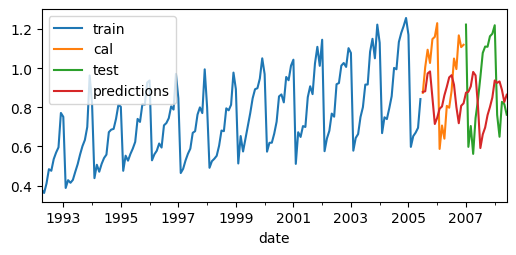

In [104]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [105]:
non_cp_preds = forecaster.predict(steps=steps)

# Predict with conformal


In [106]:
data_cal['y']


date
2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
2006-02-01    0.587135
2006-03-01    0.706959
2006-04-01    0.639641
2006-05-01    0.807405
2006-06-01    0.797970
2006-07-01    0.884312
2006-08-01    1.049648
2006-09-01    0.995709
2006-10-01    1.168253
2006-11-01    1.108038
2006-12-01    1.120053
Freq: MS, Name: y, dtype: float64

In [107]:
# Calibrate
# ==============================================================================
forecaster.calibrate_conformal(data_cal['y'])


Conformal prediction has been calibrated. The model is now ready to predict conformal intervals.



In [108]:
forecaster.regressor_conformal.valid_methods_

['enbpi', 'aci']

In [109]:
# see estimator
forecaster.regressor_conformal.estimator

RandomForestRegressor(random_state=123)

In [110]:
forecaster.regressor_conformal.method  # this should be aci, I patch it by reassigning 'aci' to it.

'enbpi'

In [111]:
# Predictions
# ==============================================================================
steps = int(steps / 2)
predictions = forecaster.predict_conformal_interval(steps=steps,
                                                    last_window = data_cal['y'],
                                                    desired_coverage= 0.9)
predictions

,pred,lower_bound,upper_bound
2007-01-01,1.030800,0.649748,1.198647
2007-02-01,0.839547,0.458495,1.007394
2007-03-01,0.666692,0.285640,0.834539
2007-04-01,0.735626,0.354574,0.903473
2007-05-01,0.774170,0.393118,0.942017
2007-06-01,0.806148,0.425096,0.973996
2007-07-01,0.862555,0.481503,1.030403
2007-08-01,1.006605,0.625553,1.174452
2007-09-01,1.050708,0.669656,1.218555
2007-10-01,1.115751,0.734698,1.283598


In [112]:
preds, y_pis = predictions['pred'].to_numpy(), predictions[['lower_bound', 'upper_bound']].to_numpy()

In [113]:
y_pis

array([[0.64974776, 1.19864733],
       [0.45849474, 1.00739431],
       [0.28563968, 0.83453925],
       [0.3545738 , 0.90347337],
       [0.39311765, 0.94201722],
       [0.42509596, 0.97399553],
       [0.48150314, 1.03040271],
       [0.62555262, 1.17445219],
       [0.66965563, 1.2185552 ],
       [0.73469843, 1.283598  ],
       [0.74466181, 1.29356138],
       [0.74397993, 1.2928795 ],
       [0.70344498, 1.25234455],
       [0.37818103, 0.9270806 ],
       [0.28496901, 0.83386858],
       [0.33271214, 0.88161171],
       [0.41129776, 0.96019733],
       [0.42310705, 0.97200662]])

In [114]:
# compare with non cp predictions to see if they are the same
np.isclose(non_cp_preds[-steps:], preds[-steps:])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [115]:
lower = y_pis[:, 0]
upper = y_pis[:, 1]

lower

array([0.64974776, 0.45849474, 0.28563968, 0.3545738 , 0.39311765,
       0.42509596, 0.48150314, 0.62555262, 0.66965563, 0.73469843,
       0.74466181, 0.74397993, 0.70344498, 0.37818103, 0.28496901,
       0.33271214, 0.41129776, 0.42310705])

In [116]:
data_test.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

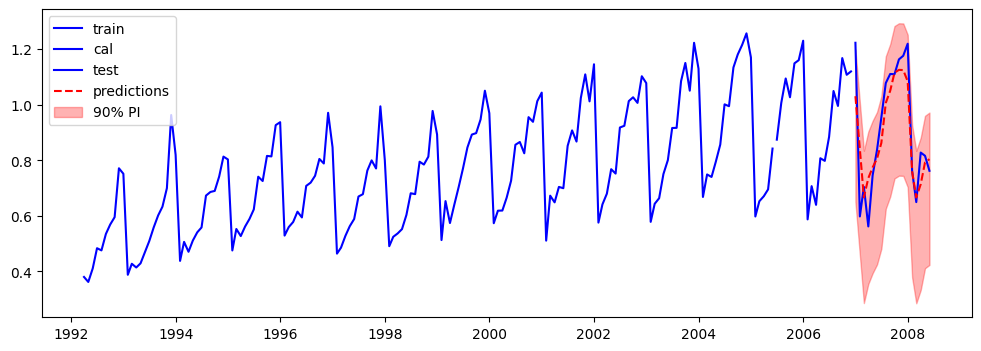

In [117]:
# visualize predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data_train.index, data_train['y'], color='blue', label='train')
ax.plot(data_cal.index, data_cal['y'], color='blue', label='cal')
ax.plot(data_test.index, data_test['y'], color='blue', label='test')

ax.plot(data_test.index, preds, color='red', linestyle='--', label='predictions')

# plot intervals
ax.fill_between(data_test.index, lower, upper, color='red', alpha=0.3, label='90% PI')


ax.legend();
plt.show()
